## Create a model that is able to predict both Age and gender based on the image presented


In [24]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
import pandas as pd, numpy as np
import os
print(os.getcwd())

import face_alignment
from skimage import io
import torch_snippets



/Users/robertocandelario/Documents/Python Projects/Age_Gender_Classification


In [25]:
path = os.path.join(os.getcwd(), "fairface-img-margin025-trainval/")

In [26]:
trn_df = pd.read_csv(path + 'fairface-labels-train.csv')
val_df = pd.read_csv(path + 'fairface-labels-val.csv')
print(val_df.iloc[5])
print()
print(val_df.iloc[5].squeeze())
f = val_df.iloc[5].squeeze()
f.file

file                  val/6.jpg
age                          35
gender                     Male
race            Latino_Hispanic
service_test              False
Name: 5, dtype: object

file                  val/6.jpg
age                          35
gender                     Male
race            Latino_Hispanic
service_test              False
Name: 5, dtype: object


'val/6.jpg'

## Create a varaible that transforms the image for both traing and Validation

In [27]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(224),
    T.CenterCrop(224),
    T.ColorJitter(brightness=(0.95, 1.05),
                  contrast=(0.95, 1.05),
                  saturation=(0.95, 1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

val_tfms = T.Compose([
        T.ToPILImage(),
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        ])

### Build a subclass Dataset 
    the subclass will take a dataframe and makes the required transformations.


In [34]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = torch_snippets.read(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        # apply face alignment to exract the facial region
        return im, age, gen
    
    
    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        _imgs, ages, genders = list(zip(*batch))
        
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        # Convert ages and genders to tensors
            ages = torch.tensor([float(age) / 80 for age in ages], dtype=torch.float32).to(device)
            genders = torch.tensor([float(gender) for gender in genders], dtype=torch.float32).to(device)

        # Concatenate images into a single tensor
        imgs = torch.cat(imgs).to(device)

        return imgs, ages, genders

## Define the dataloaders
    The dataloaders help pull batches of data for the model to be trained on


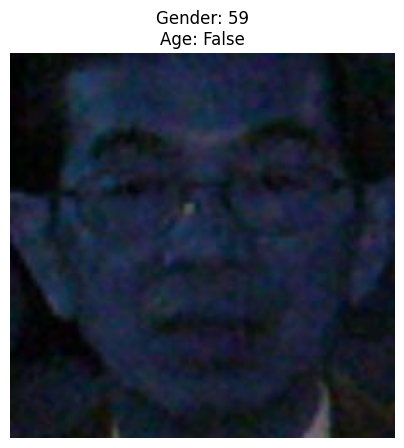

In [35]:
trn = GenderAgeClass(trn_df, transform=trn_tfms)
val = GenderAgeClass(val_df, transform=val_tfms)

train_loader = DataLoader(trn, batch_size=32, shuffle=True,
                        drop_last=True,collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32,
                        collate_fn=val.collate_fn)

im, gen, age= trn[0]
torch_snippets.show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

ims, gens, ages = next(iter(train_loader))
torch_snippets.inspect(ims, gens, ages)

## Get the pretrained model
    Free the current parameters and change the last layer 

In [36]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    ### Build a nn.Module class. This class will help us split the model to predict classification and sequential 
    
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            
            # First layer 
            self.intermediate = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU()
            )
            
            # Next two layers are the ending layers 
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    # define the loss function for both gender and age 
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_functions, optimizer

model, criterion, optimizer = get_model()

## Define function to train model on a batch

In [37]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), gender)
    
    # add both losses and perform back propagation
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

### Define validation-batch method
    Pass in correct values to see if the model is able to predict the correct values after being trained on an epoch 

In [38]:
def validate_batch(data, model, criteria):
    img, age, gender = data
    model.eval()
    with torch.no_grad():
        pred_gender, pred_age = model(img)
        gender_criterion, age_criterion = criteria
        gender_loss = gender_criterion(pred_gender.squeeze(), gender)
        age_loss = age_criterion(pred_age.squeeze(), age)
        
        total_loss = gender_loss + age_loss
        
        pred_gender = (pred_gender > 0.5).squeeze()
        gender_accuracy = (pred_gender == gender).float().sum()
        
        age_mae = torch.abs(age-pred_age).float().sum()
        return total_loss, gender_accuracy, age_mae


### Train model over 5 epochs

1
Working on training
EPOCH: 1.000  trn_loss: 0.601  (511.16s - 4600.44s remaining)Working on Validaiton
EPOCH: 1.000  val_gender_acc: 0.820  trn_loss: 0.714  val_age_mae: 14.842  val_loss: 0.884  (559.05s - 5031.41s remaining)
2
Working on training
EPOCH: 2.000  trn_loss: 0.377  (1075.71s - 4302.82s remaining)Working on Validaiton
EPOCH: 2.000  val_gender_acc: 0.815  trn_loss: 0.579  val_age_mae: 15.745  val_loss: 0.915  (1121.58s - 4486.31s remaining)
3
Working on training
EPOCH: 3.000  trn_loss: 0.475  (1641.63s - 3830.46s remaining)Working on Validaiton
EPOCH: 3.000  val_gender_acc: 0.833  trn_loss: 0.532  val_age_mae: 15.250  val_loss: 0.864  (1686.98s - 3936.30s remaining)
4
Working on training
EPOCH: 4.000  trn_loss: 0.891  (2203.43s - 3305.15s remaining)Working on Validaiton
EPOCH: 4.000  val_gender_acc: 0.840  trn_loss: 0.501  val_age_mae: 15.348  val_loss: 0.860  (2249.52s - 3374.28s remaining)
5
Working on training
EPOCH: 5.000  trn_loss: 0.478  (2776.02s - 2776.02s remainin

100%|██████████| 111/111 [00:00<00:00, 341.58it/s]


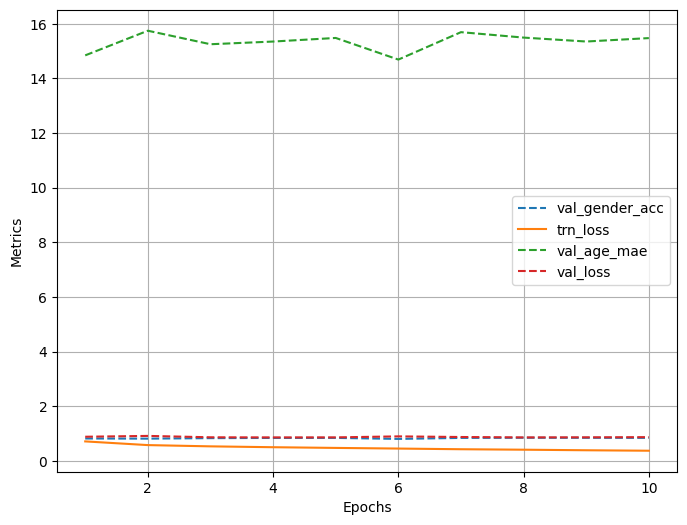

In [39]:
import time
from torch_snippets.torch_loader import Report

model, criteria, optimizer = get_model()
n_epochs = 10

log = torch_snippets.torch_loader.Report(n_epochs)

for epoch in range(n_epochs):
    print(epoch+1)
    
    # First loop, train the model
    print("Working on training")
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        if ix == N: break
        total_loss = train_batch(data, model, optimizer, criteria)
        log.record(epoch+(ix+1)/N, trn_loss=total_loss, end='\r')
    
    # Second loop, validate the model performance 
    print("Working on Validaiton")
    N = len(test_loader)
    for ix, data in enumerate(test_loader):
        if ix==N: break
        total_loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        
        # calc the overall accuracy of age prediction and gender classification
        age_mae /= len(data[0])
        gender_acc /= len(data[0])
        log.record(epoch+(ix+1)/N, val_loss=total_loss,
                   val_gender_acc=gender_acc,
                   val_age_mae=age_mae, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs()
        
        


100%|██████████| 111/111 [00:00<00:00, 425.97it/s]


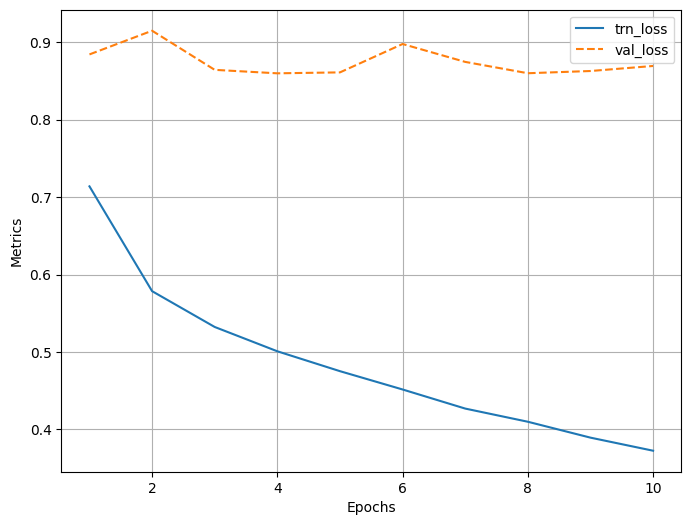

In [40]:
log.plot_epochs(['trn_loss','val_loss'])

In [44]:
# Ensure the image tensor is on the same device as the model
im_tensor = im_tensor.to(next(model.parameters()).device)

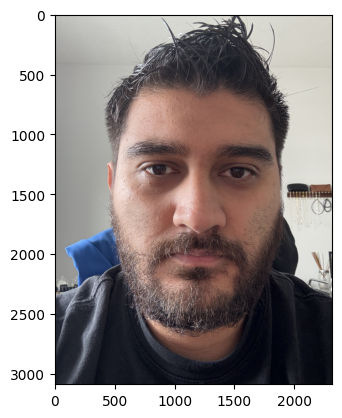

Predicted Gender: Male, Age: 0.0


In [48]:
from PIL import Image
import pillow_heif
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load HEIC image
heif_file = pillow_heif.read_heif("IMG_3428.HEIC")
im = Image.frombytes(
    heif_file.mode, 
    heif_file.size, 
    heif_file.data
)

# Define image transformations
val_tfms = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Display image before transformation
plt.imshow(im)
plt.show()

# Convert image to RGB and apply transformations
im = im.convert("RGB")  # Ensure it's in RGB format
im_tensor = val_tfms(im).unsqueeze(0)  # Add batch dimension

# Move image tensor to same device as the model
im_tensor = im_tensor.to(next(model.parameters()).device)

# Pass the preprocessed image to the model
model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    gender, age = model(im_tensor)

# Extract predictions
pred_gender = gender.to('cpu').detach().numpy().flatten()[0]
pred_age = age.to('cpu').detach().numpy().flatten()[0]

# Print results
print(f"Predicted Gender: {'Female' if pred_gender > 0.5 else 'Male'}, Age: {pred_age:.1f}")

In [49]:
im2fmap = nn.Sequential(*list(model.features[:5]) + list(model.features[5:7]))  # First 5 conv layers + 2 more layers

def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction 
    model.zero_grad()
    # compute gradients with respect to 
    # model's most confident logit
    logits[0, pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every feature map
    pooled_grads = model.features[-6][1].weight.grad.data.mean((1,2,3))
    
    # multiply each activation map with 
    # corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
        
        # take the mean of all weighted activation maps
        # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'male' if pred.item() else 'Female'
    

In [ ]:
#